In [1]:
import sys
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib import cm
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
import matplotlib
import scipy
from statistics import mean

from pymodulon.core import *
from pymodulon.plotting import *
from pymodulon.compare import *
from pymodulon.io import *


pd.options.display.max_columns = 999 

In [2]:
#format figures
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Also, if you want your axes lines to be true black, and not this weird dark gray:
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['ytick.color'] = 'black'

In [3]:
ica_data = load_json_model('../data/ecoli_modulome.json.gz')

# Gene weight plot

In [4]:
import seaborn as sns
sns.set_style('ticks')

In [5]:
def altered_plot_genes(imodulon):
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

    fig,ax = plt.subplots(figsize=(6,4.5))

    plot_gene_weights(ica_data,imodulon, ax=ax, show_labels=True)

    ax.spines['top'].set_color('0'); ax.spines['bottom'].set_color('0')
    ax.spines['left'].set_color('0'); ax.spines['right'].set_color('0')

    ax.spines['top'].set_linewidth(2); ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2); ax.spines['right'].set_linewidth(2)
    ax.grid(False)

    ax.set_ylabel('{} iModulon Gene Weight'.format(imodulon),fontsize=10, fontweight ='bold')
    ax.set_xlabel('Gene Start',fontsize=10, fontweight ='bold')

#     labels = ['','Amino acid\ntransport and\nmetabolism', 'Energy production\nand conversion',
#              'Nucleotide transport\nand metabolism', 
#              'Post-translational\nmodification, protein\nturnover,and chaperones',
#              'Transcription']

    plt.legend(bbox_to_anchor=(1,1),fontsize=9,ncol=1, markerscale=1.3, handletextpad=.1,
              frameon=False, labelspacing=.6)

    plt.savefig('./fig6/{}_genes.pdf'.format(imodulon), dpi = 600, bbox_inches = 'tight')

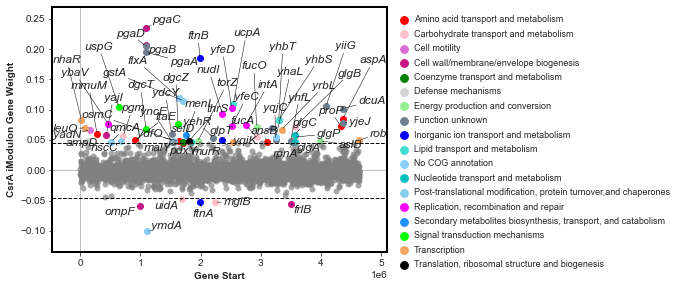

In [7]:
altered_plot_genes('CsrA')

# Activity Plot

<AxesSubplot:ylabel='CsrA iModulon\nActivity'>

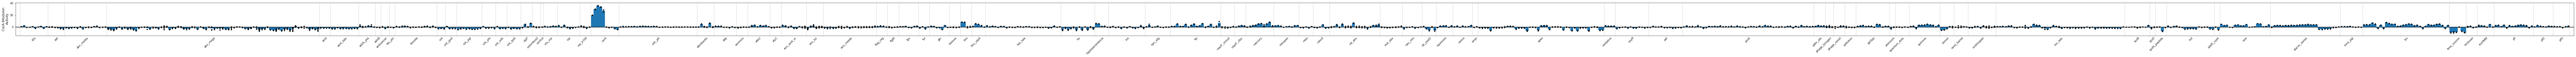

In [8]:
plot_activities(ica_data, 'CsrA')

In [9]:
CsrA_A_df = ica_data.A[ica_data.A.index == 'CsrA']
CsrA_A_df.columns = ica_data.sample_table.full_name

conditions = list(set([col for col in CsrA_A_df.columns if 'csrA' in col]))

CsrA_A_csrA_df = CsrA_A_df[conditions].T
CsrA_A_csrA_df.sort_values(by='CsrA', ascending=True, inplace=True)

CsrA_pivot = CsrA_A_csrA_df.reset_index().pivot_table(columns=["full_name"])[conditions].T


CsrA_pivot

,CsrA
full_name,
csrA:wt_t00,0.000000
csrA:delcsrA_t10,33.945776
csrA:delcsrA_t15,27.188620
csrA:delcsrA_t02_30,29.913172
csrA:delcsrA_t00,19.998336
csrA:wt_t15,-4.215546
csrA:delcsrA_t05,36.075988
csrA:wt_t05,-0.247102
csrA:wt_t02_30,-0.982752


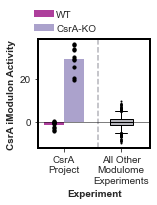

In [10]:
fig, ax1 = plt.subplots(figsize=(2,2))

# bar plot
labels = ['CsrA\nProject',  'All Other\nModulome\nExperiments']
wt = [mean(CsrA_pivot[CsrA_pivot.index.str.contains('wt')].CsrA.to_list())]+[0]
delcsrA = [mean(CsrA_pivot[CsrA_pivot.index.str.contains('delcsrA')].CsrA.to_list())]+[0]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax1.bar(x - width/2, wt, width, label='WT', lw=0, color='#ae3f9c')
rects2 = ax1.bar(x + width/2, delcsrA, width, label='CsrA-KO', lw=0, color = '#aba2cc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('CsrA iModulon Activity', fontsize=10, fontweight='bold')
ax1.set_xlabel('Experiment', fontsize=10, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(bbox_to_anchor=(0.6,1.35), frameon=False, ncol=1, 
           columnspacing=2, handletextpad=.2)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
autolabel(rects1)
autolabel(rects2)

# scatterpoints
scatter_x = []
for i in x[:-1]:
    scatter_x.extend([i-width/2]*10+ [i+width/2]*10)
ax1.scatter(scatter_x, CsrA_A_csrA_df.CsrA, color="k", zorder=2, s=10)


# boxplot
ax1.axvline(0.6, color='#B4B4BB', ls='--')
ax1.axhline(0, color='k', lw=0.5)
flierprops = dict(marker='o', markersize=1,
                  linestyle='none', markeredgecolor='k')
ax1.boxplot(CsrA_A_df.T[~CsrA_A_df.T.index.isin(conditions)].CsrA.to_list(), 
            positions=[1], flierprops=flierprops, widths=[.4], 
            patch_artist=True, boxprops= dict(facecolor='#b4b4bb'),
            medianprops=dict(color='k'))

ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# more formatting
ax1.spines['top'].set_color('0'); ax1.spines['bottom'].set_color('0')
ax1.spines['left'].set_color('0'); ax1.spines['right'].set_color('0')
ax1.spines['top'].set_linewidth(2); ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2); ax1.spines['right'].set_linewidth(2)

plt.savefig('./fig6/CsrA_activity.pdf', dpi = 600, bbox_inches = 'tight')

In [11]:
print('publication: ',ica_data.sample_table[ica_data.sample_table.project == 'csrA'].PMID.unique())

publication:  ['29150605']


# Regulon

<AxesSubplot:xlabel='CsrA Gene Weight', ylabel='Number of Genes'>

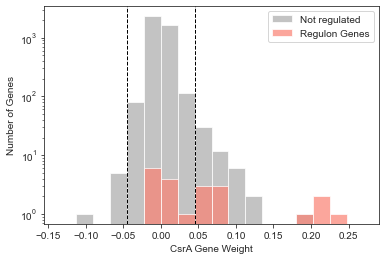

In [12]:
plot_regulon_histogram(ica_data, 'CsrA')

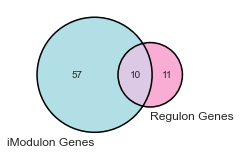

In [14]:
reg = ica_data.trn[ica_data.trn.regulator=='CsrA'].gene_name.to_list()
iM = ica_data.view_imodulon('CsrA').gene_name.to_list()

plt.figure(figsize=(3,3))
v = venn2([set(iM), set(reg)], set_labels= ('iModulon Genes', 'Regulon Genes'))
c = venn2_circles([set(iM), set(reg)], lw=1.5)

v.get_patch_by_id('100').set_color('#3FB1BE')
v.get_patch_by_id('110').set_color('#A87ABE')
v.get_patch_by_id('010').set_color('#F13497')

plt.savefig('./fig6/csrA_reg_venn.pdf', dpi = 600, bbox_inches = 'tight')

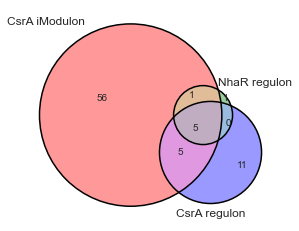

In [15]:
reg = ica_data.trn[ica_data.trn.regulator=='NhaR'].gene_name.to_list() 
nhaR = ica_data.view_imodulon('CsrA').gene_name.to_list()
csrA = ica_data.trn[ica_data.trn.regulator=='CsrA'].gene_name.to_list()

v = venn3([set(nhaR), set(reg), set(csrA)], set_labels = ('CsrA iModulon', 'NhaR regulon', 'CsrA regulon'))
c = venn3_circles([set(nhaR), set(reg), set(csrA)], lw=1.5)

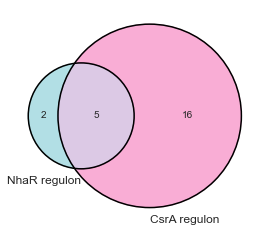

In [16]:
nhaR = ica_data.trn[ica_data.trn.regulator=='NhaR'].gene_name.to_list() 
csrA = ica_data.trn[ica_data.trn.regulator=='CsrA'].gene_name.to_list()

v = venn2([set(nhaR),  set(csrA)], set_labels = ( 'NhaR regulon', 'CsrA regulon'))
c = venn2_circles([set(nhaR), set(csrA)], lw=1.5)

v.get_patch_by_id('100').set_color('#3FB1BE')
v.get_patch_by_id('110').set_color('#A87ABE')
v.get_patch_by_id('010').set_color('#F13497')

In [18]:
ica_data.compute_trn_enrichment('CsrA')

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,CsrA,CsrA,1.596234e-13,1.181213e-11,0.149254,0.476190,0.227273,10.0,21.0,67.0,1.0
1,CsrA,NhaR,8.940146e-11,3.307854e-09,0.089552,0.857143,0.162162,6.0,7.0,67.0,1.0


In [20]:
ica_data.imodulon_table.loc['CsrA',:]

regulator                                              CsrA
pvalue                                          1.59623e-13
qvalue                                          1.18121e-11
precision                                          0.149254
recall                                              0.47619
f1score                                            0.227273
TP                                                       10
regulon_size                                             21
imodulon_size                                            67
n_regs                                                    1
p2_im                                                   NaN
enrichment_params                                       NaN
p2_corr                                                 NaN
enrichment_category                              Regulatory
exp_var                                            0.209346
single_gene                                             NaN
notes                  may be grounds fo

# Rename iModulon

In [ ]:
# ica_data.rename_imodulons({'NhaR':'CsrA'})

# ica_data.compute_trn_enrichment('CsrA', save=True)

In [ ]:
# ica_data.imodulon_table.loc['CsrA',:]

In [ ]:
# save_to_json(ica_data, '../data/ecoli_modulome.json.gz')